# Pipeline de Aprendizado de Máquina para Previsão de Doenças Cardíacas

Este notebook implementa um pipeline completo de aprendizado de máquina para previsão de doenças cardíacas usando o conjunto de dados de Doenças Cardíacas da UCI. O pipeline inclui carregamento de dados, pré-processamento, engenharia de recursos, treinamento de modelos, avaliação e recursos de previsão.

## 1. Importar bibliotecas necessárias

In [105]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Bibliotecas de aprendizado de máquina
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Bibliotecas de banco de dados
import os
from sqlalchemy import create_engine, Column, Integer, Float, String, DateTime, Text, Boolean
from sqlalchemy.orm import declarative_base, sessionmaker
from datetime import datetime
import json

# Bibliotecas utilitárias
import warnings
warnings.filterwarnings('ignore')

# Definir estilo de plotagem
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 2. Configuração do Banco de Dados (Opcional)

Configure o esquema do banco de dados para rastreamento de experimentos e registro de previsões.

In [106]:
# Configuração do banco de dados
Base = declarative_base()

class ExperimentRun(Base):
    __tablename__ = 'experiment_runs'
    
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime, default=datetime.utcnow)
    dataset_samples = Column(Integer)
    train_samples = Column(Integer)
    val_samples = Column(Integer)
    test_samples = Column(Integer)
    val_accuracy = Column(Float)
    test_accuracy = Column(Float)
    model_params = Column(Text)  # JSON string
    feature_importance = Column(Text)  # JSON string

class Prediction(Base):
    __tablename__ = 'predictions'
    
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime, default=datetime.utcnow)
    experiment_id = Column(Integer)
    input_features = Column(Text)  # JSON string
    predicted_class = Column(Integer)
    prediction_probability = Column(Float)
    true_label = Column(Integer, nullable=True)
    is_correct = Column(Boolean, nullable=True)

def init_database():
    """Inicializar conexão com o banco de dados e criar tabelas"""
    try:
        database_url = os.getenv('DATABASE_URL')
        if not database_url:
            print("URL do banco de dados não encontrada. Ignorando configuração do banco de dados.")
            return None
        
        engine = create_engine(database_url)
        Base.metadata.create_all(engine)
        Session = sessionmaker(bind=engine)
        return Session()
    except Exception as e:
        print(f"Falha na conexão com o banco de dados: {str(e)}")
        return None

# Initialize database session
db_session = init_database()

URL do banco de dados não encontrada. Ignorando configuração do banco de dados.


## 3. Carregamento de Dados e Visão Geral

Carregue o conjunto de dados de Doenças Cardíacas do Repositório de ML da UCI e exiba informações básicas.

In [107]:
def load_dataset():
    """Carregar o conjunto de dados de doenças cardíacas do repositório UCI ML"""
    try:
        from ucimlrepo import fetch_ucirepo
        
        print("Carregando conjunto de dados de doenças cardíacas do repositório UCI ML...")
        heart_disease = fetch_ucirepo(id=45)
        X = heart_disease.data.features
        y = heart_disease.data.targets
        
        # Combine features and target into a single DataFrame
        df = X.copy()
        df['target'] = y
        
        print("✅ Conjunto de dados carregado com sucesso!")
        return df, heart_disease
    except Exception as e:
        print(f"❌ Erro ao carregar conjunto de dados: {str(e)}")
        print("💡 Certifique-se de ter o pacote 'ucimlrepo' instalado: pip install ucimlrepo")
        return None, None

# Load the dataset
df, heart_disease_info = load_dataset()

if df is not None:
    # Após o carregamento e pré-processamento inicial dos dados
    print(f"\nFormato do conjunto de dados: {df.shape}")
    print(f"Características: {df.shape[1] - 1}")
    print(f"Amostras: {df.shape[0]}")
    print(f"Classes do alvo: {df['target'].nunique()}")
    print(f"Valores ausentes: {df.isnull().sum().sum()}")

Carregando conjunto de dados de doenças cardíacas do repositório UCI ML...
✅ Conjunto de dados carregado com sucesso!

Formato do conjunto de dados: (303, 14)
Características: 13
Amostras: 303
Classes do alvo: 5
Valores ausentes: 6


In [108]:
# Display first few rows
if df is not None:
    print("Primeiras 5 linhas do conjunto de dados:")
    display(df.head())
    
    print("\nDabase informação:")
    df.info()

Primeiras 5 linhas do conjunto de dados:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



Dabase informação:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


## 4. Estatística Descritiva e Exploração de Dados

Analise as características do conjunto de dados e visualize a distribuição dos dados.

In [109]:
if df is not None:
    # Estatísticas básicas
    print("Estatísticas de recursos numéricos:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    display(df[numeric_cols].describe())

Estatísticas de recursos numéricos:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


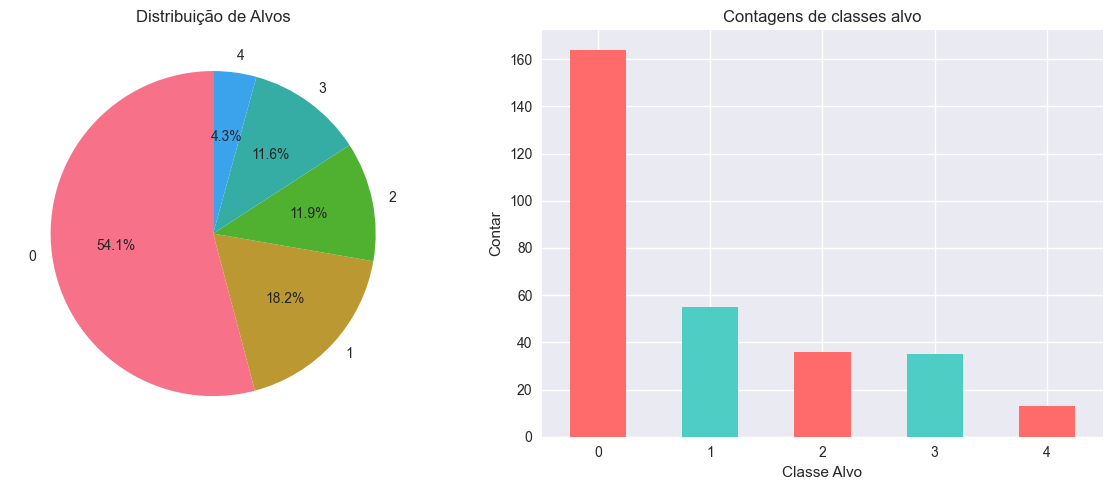

In [110]:
if df is not None:
    # Distribuição alvo
    target_counts = df['target'].value_counts()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Gráfico de pizza
    ax1.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Distribuição de Alvos')
    
    # Gráfico de barras
    target_counts.plot(kind='bar', ax=ax2, color=['#ff6b6b', '#4ecdc4'])
    ax2.set_title('Contagens de classes alvo')
    ax2.set_xlabel('Classe Alvo')
    ax2.set_ylabel('Contar')
    ax2.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

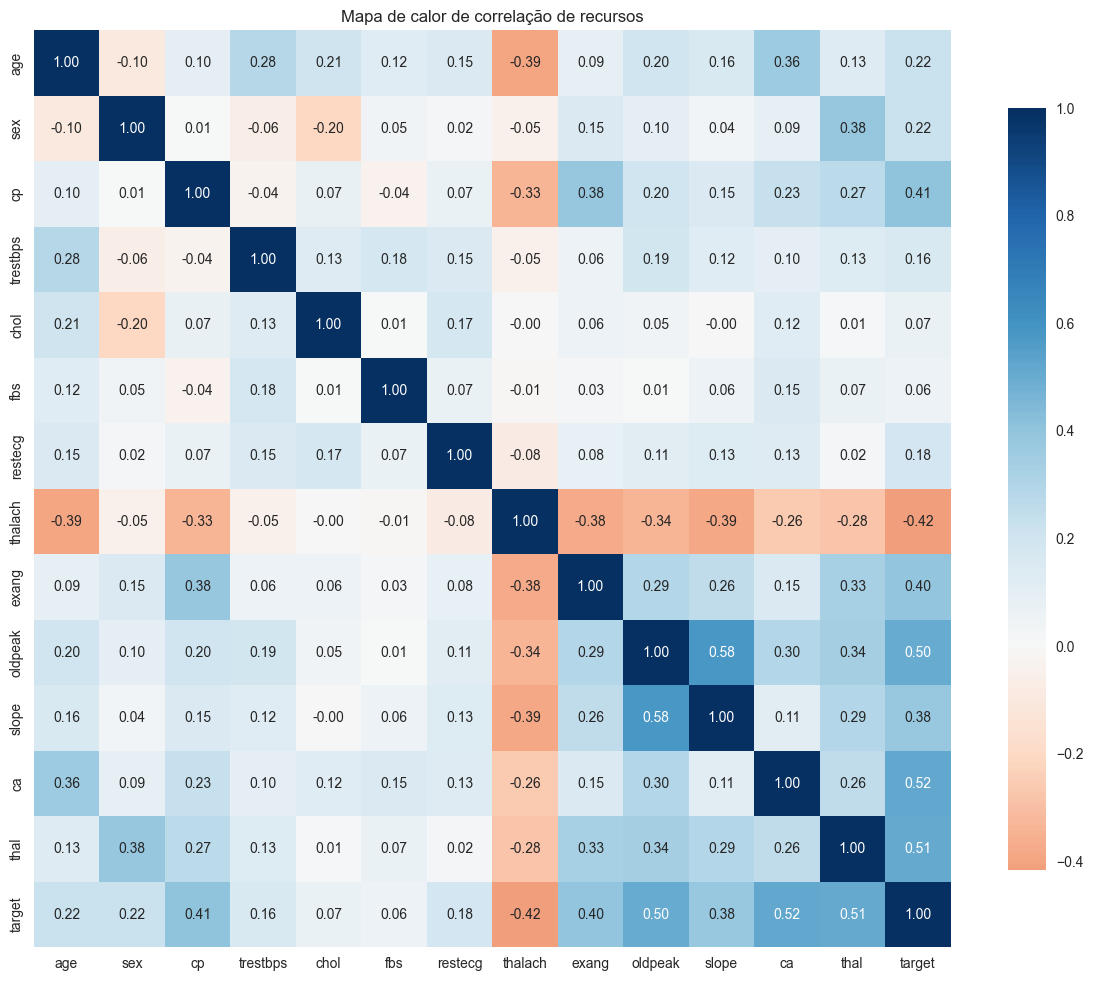

In [111]:
if df is not None:
    # Correlações de recursos
    correlation_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Mapa de calor de correlação de recursos')
    plt.tight_layout()
    plt.show()

## 5. Engenharia de Recursos

Aplique transformações de recursos e crie novos recursos.

In [112]:
def apply_feature_engineering(df):
    """Aplicar transformações de engenharia de recursos"""
    if df is None:
        return None
    
    print("Aplicando Engenharia de Recursos...")
    
    # Lidar com valores ausentes
    missing_before = df.isnull().sum().sum()
    if missing_before > 0:
        print(f"⚠️ Encontrado {missing_before} valores ausentes. Preenchendo com valores medianos para colunas numéricas.")
        df_clean = df.copy()
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
    else:
        print("✅ Nenhum valor faltante encontrado!")
        df_clean = df.copy()
    
    # Engenharia de recursos: Criar razão_de_idade_de_colesterol
    print("Criando novo recurso: Razão Colesterol-Idade")
    
    if 'chol' in df_clean.columns and 'age' in df_clean.columns:
        df_clean['chol_age_ratio'] = df_clean['chol'] / df_clean['age']
        print("✅ Criado o recurso 'chol_age_ratio'")
        
        print(f"Razão Média: {df_clean['chol_age_ratio'].mean():.2f}")
        print(f"Razão Padrão: {df_clean['chol_age_ratio'].std():.2f}")
    else:
        print("❌ Colunas obrigatórias 'chol' e 'age' não encontradas para engenharia de recursos")
        return df_clean
    
    return df_clean

# Aplicar engenharia de recursos
df_engineered = apply_feature_engineering(df)

Aplicando Engenharia de Recursos...
⚠️ Encontrado 6 valores ausentes. Preenchendo com valores medianos para colunas numéricas.
Criando novo recurso: Razão Colesterol-Idade
✅ Criado o recurso 'chol_age_ratio'
Razão Média: 4.63
Razão Padrão: 1.10


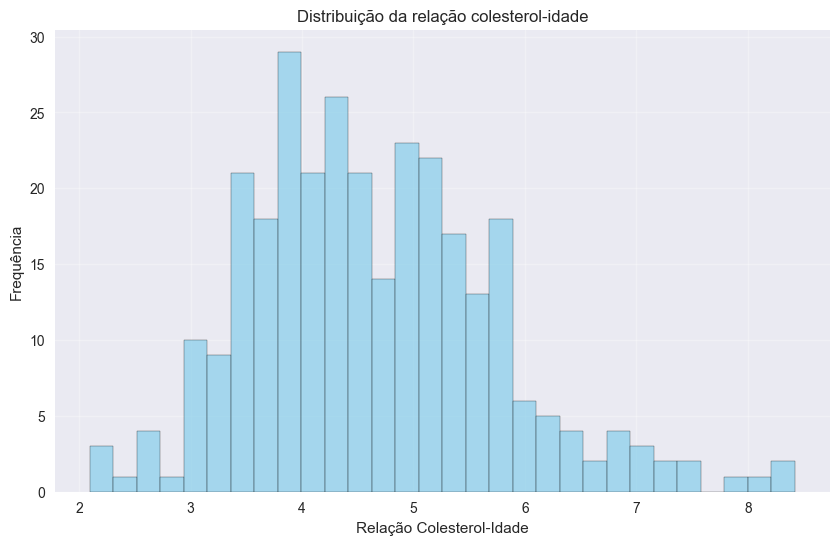

In [113]:
if df_engineered is not None and 'chol_age_ratio' in df_engineered.columns:
    # Visualize o novo recurso
    plt.figure(figsize=(10, 6))
    plt.hist(df_engineered['chol_age_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribuição da relação colesterol-idade')
    plt.xlabel('Relação Colesterol-Idade')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.show()

## 6. Remoção de Valores Atípicos

Remova valores atípicos com base no limite do quantil.

In [114]:
def apply_outlier_removal(df, outlier_threshold=0.05):
    """Remover outliers com base no limite do quantil"""
    if df is None:
        return None
    
    print("Aplicando remoção de outliers...")
    
    if 'chol_age_ratio' not in df.columns:
        print("❌ Coluna 'chol_age_ratio' não encontrada. Não é possível aplicar remoção de outliers.")
        return df
    
    # Calculando o quantil para o limiar de outlier
    q_threshold = df['chol_age_ratio'].quantile(outlier_threshold)
    
    # Remove outliers
    df_filtered = df[df['chol_age_ratio'] >= q_threshold].copy()
    
    removed_count = len(df) - len(df_filtered)
    
    print(f"Amostras originais: {len(df)}")
    print(f"Outliers removidos: {removed_count}")
    print(f"Amostras restantes: {len(df_filtered)}")
    
    if removed_count > 0:
        print(f"✅ Removido {removed_count} outliers (chol_age_ratio < {q_threshold:.2f})")
    else:
        print("ℹ️ Nenhum valor discrepante foi removido com o limite atual")
    
    return df_filtered

# Aplicar remoção de outliers
df_processed = apply_outlier_removal(df_engineered)

Aplicando remoção de outliers...
Amostras originais: 303
Outliers removidos: 16
Amostras restantes: 287
✅ Removido 16 outliers (chol_age_ratio < 3.08)


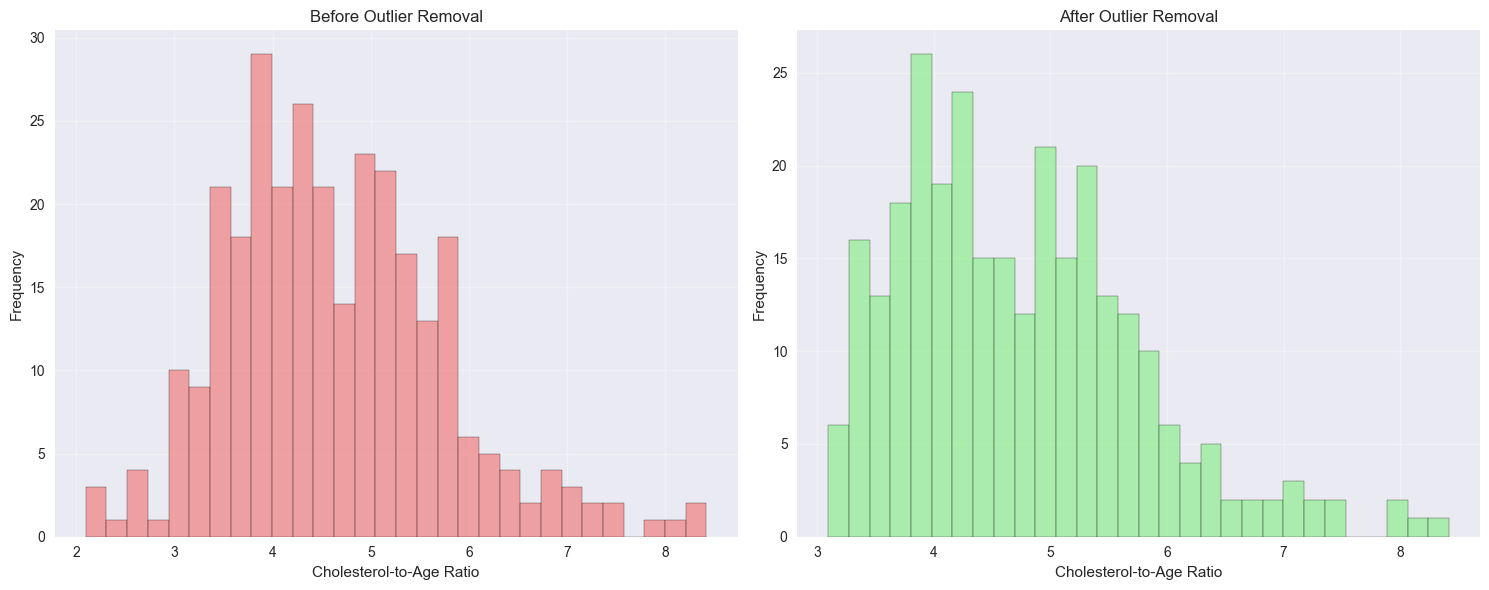

In [115]:
if df_engineered is not None and df_processed is not None and 'chol_age_ratio' in df_engineered.columns:
    # Visualize before and after outlier removal
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Before outlier removal
    ax1.hist(df_engineered['chol_age_ratio'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    ax1.set_title('Before Outlier Removal')
    ax1.set_xlabel('Cholesterol-to-Age Ratio')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # After outlier removal
    ax2.hist(df_processed['chol_age_ratio'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.set_title('After Outlier Removal')
    ax2.set_xlabel('Cholesterol-to-Age Ratio')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Divisão de Dados

Crie divisões de treinamento, validação e teste com dimensionamento adequado.

In [116]:
def create_data_splits(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """Criar divisões de treinamento, validação e teste"""
    if df is None:
        return None
    
    print("Criando Divisões de Dados...")
    
    # Validate split sizes
    if abs(train_size + val_size + test_size - 1.0) > 0.001:
        print("❌ Os tamanhos das divisões devem somar 1,0")
        return None
    
    # Separar recursos e alvo
    X = df.drop('target', axis=1)
    y = df['target']
    
    # Primeira divisão: trem vs temp (val + teste)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, 
        test_size=(val_size + test_size), 
        random_state=random_state, 
        stratify=y
    )
    
    # Segunda divisão: validação vs teste
    relative_test_size = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, 
        test_size=relative_test_size, 
        random_state=random_state, 
        stratify=y_temp
    )
    
    # Exibir tamanhos das divisões
    print(f"Conjunto de treinamento: {len(X_train)} amostras ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Conjunto de validação: {len(X_val)} amostras ({len(X_val)/len(df)*100:.1f}%)")
    print(f"Conjunto de teste: {len(X_test)} amostras ({len(X_test)/len(df)*100:.1f}%)")
    
    # Scale the features
    print("Recursos de dimensionamento...")
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Converta de volta para DataFrames para facilitar o manuseio
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print("✅ Divisão e dimensionamento de dados concluídos!")
    
    return {
        'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'scaler': scaler
    }

# Criar divisões de dados
data_splits = create_data_splits(df_processed)

Criando Divisões de Dados...
Conjunto de treinamento: 200 amostras (69.7%)
Conjunto de validação: 43 amostras (15.0%)
Conjunto de teste: 44 amostras (15.3%)
Recursos de dimensionamento...
✅ Divisão e dimensionamento de dados concluídos!


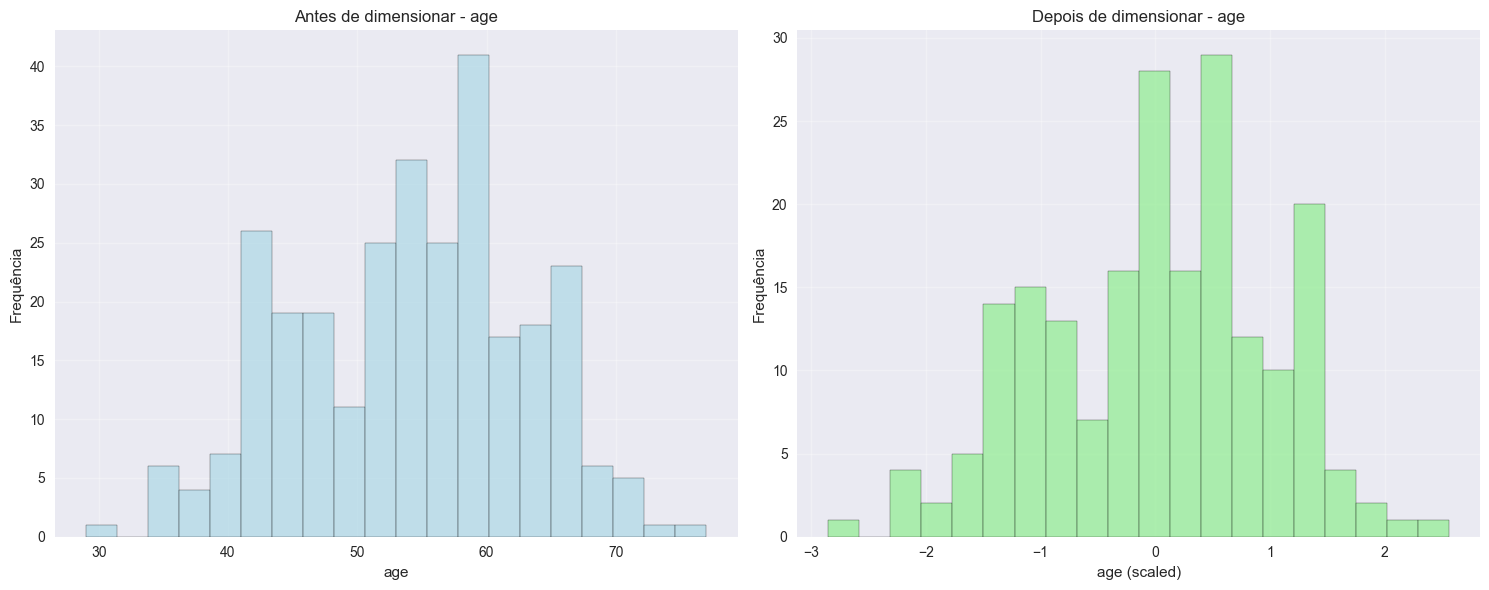

In [117]:
if data_splits is not None:
    # Visualize the effect of scaling on a feature
    feature_to_show = data_splits['X_train'].columns[0]  # primeiro recurso
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Antes do dimensionamento (usando dados originais)
    original_feature = df_processed.drop('target', axis=1)[feature_to_show]
    ax1.hist(original_feature, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    ax1.set_title(f'Antes de dimensionar - {feature_to_show}')
    ax1.set_xlabel(feature_to_show)
    ax1.set_ylabel('Frequência')
    ax1.grid(True, alpha=0.3)
    
    # Depois do dimensionamento (usando dados de treinamento)
    ax2.hist(data_splits['X_train'][feature_to_show], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.set_title(f'Depois de dimensionar - {feature_to_show}')
    ax2.set_xlabel(f'{feature_to_show} (scaled)')
    ax2.set_ylabel('Frequência')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Treinamento do Modelo

Treine um modelo de Árvore de Decisão com parâmetros configuráveis.

In [118]:
def train_model(data_splits, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42):
    """Treinar um modelo de árvore de decisão com os dados fornecidos"""
    if data_splits is None:
        return None
    
    print("Modelo de Treinamento...")
    
    # Inicializar modelo com parâmetros
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    
    # Treinar o modelo
    model.fit(data_splits['X_train'], data_splits['y_train'])
    
    # Avaliar o modelo no conjunto de validação
    y_pred_val = model.predict(data_splits['X_val'])
    val_accuracy = accuracy_score(data_splits['y_val'], y_pred_val)
    
    print("✅ Treinamento do modelo concluído com sucesso!")
    print(f"Tipo de modelo: Classificador de árvore de decisão")
    print(f"Amostras de treinamento: {len(data_splits['X_train'])}")
    print(f"Precisão de validação: {val_accuracy:.4f}")
    
    return model

# Treinar o modelo com os dados divididos
model = train_model(data_splits)

Modelo de Treinamento...
✅ Treinamento do modelo concluído com sucesso!
Tipo de modelo: Classificador de árvore de decisão
Amostras de treinamento: 200
Precisão de validação: 0.5581


## 9. Avaliação do Modelo

Avaliação abrangente, incluindo métricas de precisão, matriz de confusão e importância dos recursos.

In [119]:
def evaluate_model(model, data_splits):
    """Avaliação abrangente do modelo"""
    if model is None or data_splits is None:
        return None
    
    print("Avaliando o modelo...")
    
    # Prever no conjunto de validação e teste
    y_pred_val = model.predict(data_splits['X_val'])
    y_pred_test = model.predict(data_splits['X_test'])
    
    # Calcular precisão
    val_accuracy = accuracy_score(data_splits['y_val'], y_pred_val)
    test_accuracy = accuracy_score(data_splits['y_test'], y_pred_test)
    
    print(f"Precisão de validação: {val_accuracy:.4f}")
    print(f"Precisão do teste: {test_accuracy:.4f}")
    
    # Confusão Matriz
    cm_test = confusion_matrix(data_splits['y_test'], y_pred_test)
    
    # Classificando Relatório
    report = classification_report(
        data_splits['y_test'], 
        y_pred_test, 
        output_dict=True
    )
    
    # Importância dos recursos
    feature_importance = pd.DataFrame({
        'feature': data_splits['X_train'].columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'confusion_matrix': cm_test,
        'classification_report': report,
        'feature_importance': feature_importance
    }

# Evaluate the model
model_results = evaluate_model(model, data_splits)

Avaliando o modelo...
Precisão de validação: 0.5581
Precisão do teste: 0.4773


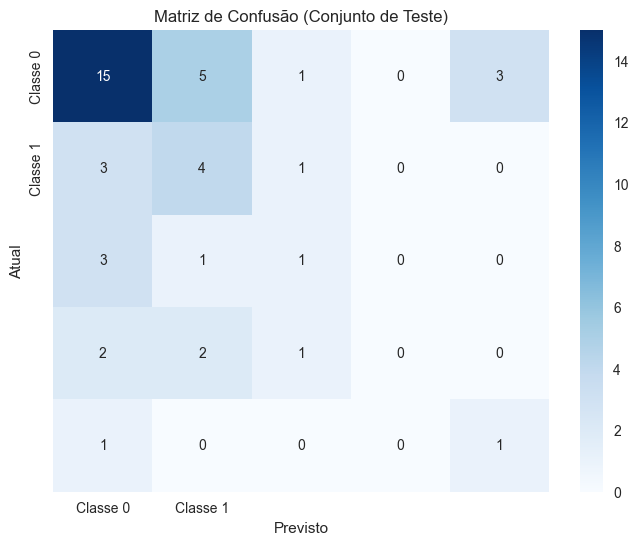

In [120]:
if model_results is not None:
    # Exibir relatório de classificação
    plt.figure(figsize=(8, 6))
    sns.heatmap(model_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.title('Matriz de Confusão (Conjunto de Teste)')
    plt.xlabel('Previsto')
    plt.ylabel('Atual')
    plt.show()

In [121]:
if model_results is not None:
    # Exibir relatório de classificação
    print("Relatório de Classificação: ")
    report_df = pd.DataFrame(model_results['classification_report']).transpose()
    display(report_df)

Relatório de Classificação: 


,precision,recall,f1-score,support
0,0.625000,0.625000,0.625000,24.000000
1,0.333333,0.500000,0.400000,8.000000
2,0.250000,0.200000,0.222222,5.000000
3,0.000000,0.000000,0.000000,5.000000
4,0.250000,0.500000,0.333333,2.000000
accuracy,0.477273,0.477273,0.477273,0.477273
macro avg,0.291667,0.365000,0.316111,44.000000
weighted avg,0.441288,0.477273,0.454040,44.000000


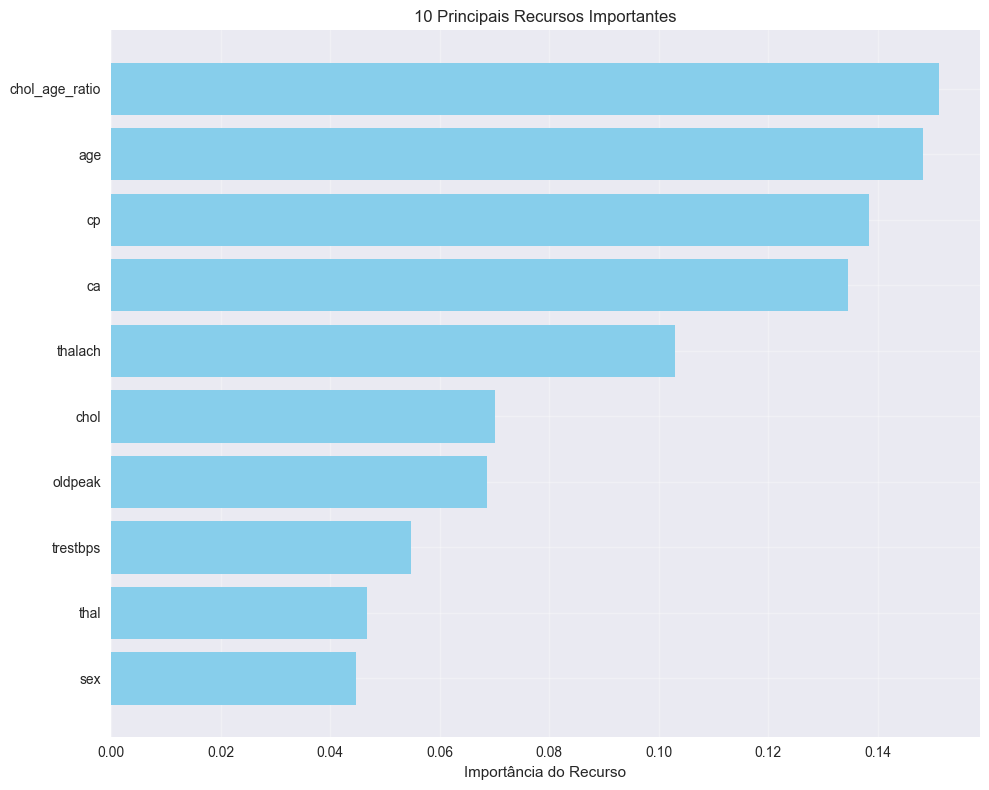

In [122]:
if model_results is not None:
    # Exibir Importância dos Recursos
    top_features = model_results['feature_importance'].head(10)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importância do Recurso')
    plt.title('10 Principais Recursos Importantes')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 10. Fazendo Previsões

Teste o modelo com dados de amostra e faça previsões.

In [123]:
def make_sample_prediction(model, data_splits, sample_idx=0):
    """Faça uma previsão em uma amostra do conjunto de teste"""
    if model is None or data_splits is None:
        return None
    
    # Verifique se o índice da amostra está dentro do intervalo
    sample_data = data_splits['X_test'].iloc[sample_idx]
    true_label = data_splits['y_test'].iloc[sample_idx]
    
    # Faça a previsão
    prediction = model.predict(sample_data.values.reshape(1, -1))[0]
    prediction_proba = model.predict_proba(sample_data.values.reshape(1, -1))[0]
    
    # Exibir resultados da previsão
    print(f"Amostra {sample_idx + 1} Previsão de Resultados:")
    print(f"Verdadeiro rótulo: {int(true_label)}")
    print(f"Previsão do Rótulo: {int(prediction)}")
    print(f"Resultados: {'✅ Corretos' if prediction == true_label else '❌ Incorretos'}")
    print(f"Previsão de Probabilidades: {prediction_proba}")
    print(f"Confiança: {max(prediction_proba):.3f}")
    
    # Exibir dados de amostra
    print("\nAmostra de Dados de entrada:")
    sample_df = pd.DataFrame(sample_data).T
    display(sample_df)
    
    return {
        'sample_data': sample_data,
        'true_label': true_label,
        'prediction': prediction,
        'prediction_proba': prediction_proba
    }

# Fazer previsões de amostra
if model is not None and data_splits is not None:
    print("Fazendo previsões de amostra por conjunto de teste:")
    print("=" * 50)
    
    # Test first 3 samples
    for i in range(min(3, len(data_splits['X_test']))):
        result = make_sample_prediction(model, data_splits, i)
        print("\n" + "-" * 50 + "\n")

Fazendo previsões de amostra por conjunto de teste:
Amostra 1 Previsão de Resultados:
Verdadeiro rótulo: 3
Previsão do Rótulo: 1
Resultados: ❌ Incorretos
Previsão de Probabilidades: [0. 1. 0. 0. 0.]
Confiança: 1.000

Amostra de Dados de entrada:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
97,0.642767,-1.603567,0.881942,1.050072,0.145392,-0.411814,0.948815,0.30391,-0.725753,1.554194,0.66494,1.40133,1.161388,-0.386255



--------------------------------------------------

Amostra 2 Previsão de Resultados:
Verdadeiro rótulo: 4
Previsão do Rótulo: 4
Resultados: ✅ Corretos
Previsão de Probabilidades: [0. 0. 0. 0. 1.]
Confiança: 1.000

Amostra de Dados de entrada:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
174,1.093435,0.62361,0.881942,0.769004,-0.742794,-0.411814,0.948815,-0.790078,-0.725753,0.996135,0.66494,1.40133,0.64636,-1.356983



--------------------------------------------------

Amostra 3 Previsão de Resultados:
Verdadeiro rótulo: 3
Previsão do Rótulo: 0
Resultados: ❌ Incorretos
Previsão de Probabilidades: [1. 0. 0. 0. 0.]
Confiança: 1.000

Amostra de Dados de entrada:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
180,-0.70924,0.62361,0.881942,-0.411484,0.454327,-0.411814,0.948815,0.697745,-0.725753,-0.399012,0.66494,-0.738105,1.161388,0.998159



--------------------------------------------------



Amostra 1 Previsão de Resultados:
Verdadeiro rótulo: 3
Previsão do Rótulo: 1
Resultados: ❌ Incorretos
Previsão de Probabilidades: [0. 1. 0. 0. 0.]
Confiança: 1.000

Amostra de Dados de entrada:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,chol_age_ratio
97,0.642767,-1.603567,0.881942,1.050072,0.145392,-0.411814,0.948815,0.30391,-0.725753,1.554194,0.66494,1.40133,1.161388,-0.386255


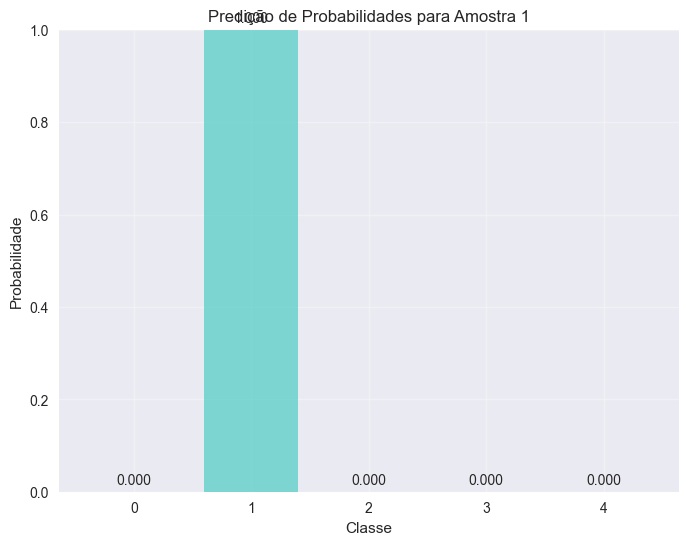

In [124]:
if model is not None and data_splits is not None:
    # Visualize the prediction probabilities for the first sample
    sample_result = make_sample_prediction(model, data_splits, 0)
    
    if sample_result is not None:
        classes = model.classes_
        probabilities = sample_result['prediction_proba']
        
        plt.figure(figsize=(8, 6))
        bars = plt.bar(classes, probabilities, color=['#ff6b6b', '#4ecdc4'], alpha=0.7)
        plt.xlabel('Classe')
        plt.ylabel('Probabilidade')
        plt.title('Predição de Probabilidades para Amostra 1')
        plt.ylim(0, 1)
        
        # Adicionar rótulos de probabilidade acima das barras
        for bar, prob in zip(bars, probabilities):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{prob:.3f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.show()

## 11. Salvar os Resultados do Experimento (Opcional)

Salve os resultados do experimento no banco de dados para rastreamento e comparação.

In [125]:
def save_experiment_results(db_session, df, data_splits, model, model_results):
    """Salvar resultados do experimento no banco de dados"""
    if db_session is None:
        print("Sessão de banco de dados indisponível. Ignorando salvamento.")
        return None
    
    try:
        model_params = {
            'max_depth': getattr(model, 'max_depth', None),
            'min_samples_split': getattr(model, 'min_samples_split', 2),
            'min_samples_leaf': getattr(model, 'min_samples_leaf', 1),
            'random_state': getattr(model, 'random_state', None)
        }
        
        experiment = ExperimentRun(
            dataset_samples=len(df),
            train_samples=len(data_splits['X_train']),
            val_samples=len(data_splits['X_val']),
            test_samples=len(data_splits['X_test']),
            val_accuracy=model_results['val_accuracy'],
            test_accuracy=model_results['test_accuracy'],
            model_params=json.dumps(model_params),
            feature_importance=json.dumps(model_results['feature_importance'].to_dict('records'))
        )
        
        db_session.add(experiment)
        db_session.commit()
        
        print(f"✅ Experimento salvo com ID: {experiment.id}")
        return experiment.id
    except Exception as e:
        print(f"Falha ao salvar o experimento: {str(e)}")
        db_session.rollback()
        return None

# Salvar resultados do experimento
if (db_session is not None and model is not None and 
    model_results is not None and data_splits is not None):
    experiment_id = save_experiment_results(db_session, df_processed, data_splits, model, model_results)
else:
    print("Ignorando salvamento do experimento - requisitos ausentes ou banco de dados indisponível")

Ignorando salvamento do experimento - requisitos ausentes ou banco de dados indisponível


## 12. Relatório Resumido

Gere um relatório resumido abrangente dos resultados do pipeline de ML.

In [126]:
def generate_summary_report(df, model_results, data_splits):
    """Gerar um relatório de resumo abrangente"""
    if df is None or model_results is None or data_splits is None:
        print("Não é possível gerar relatório - dados ausentes")
        return
    
    print("=" * 60)
    print(" PIPELINE DE ML DE PREVISÃO DE DOENÇAS CARDÍACAS")
    print(" RELATÓRIO RESUMO")
    print("=" * 60)
    print()

    print("📊 RESUMO DO CONJUNTO DE DADOS")
    print("-" * 30)
    print(f"Total de Amostras: {len(df)}")
    print(f"Recursos: {len(df.columns) - 1}")
    print(f"Classes-alvo: {df['target'].nunique()}")
    print(f"Valores Ausentes: {df.isnull().sum().sum()}")
    print()
    
    print("📈 PERFORMANCE DO MODELO")
    print("-" * 30)
    print(f"Precisão de validação: {model_results['val_accuracy']:.4f}")
    print(f"Precisão do teste: {model_results['test_accuracy']:.4f}")
    print()
    
    print("📋 DIVISÕES DE DADOS")
    print("-" * 30)
    total_samples = len(data_splits['X_train']) + len(data_splits['X_val']) + len(data_splits['X_test'])
    print(f"Treinamento: {len(data_splits['X_train'])} ({len(data_splits['X_train'])/total_samples*100:.1f}%)")
    print(f"Validação: {len(data_splits['X_val'])} ({len(data_splits['X_val'])/total_samples*100:.1f}%)")
    print(f"Teste: {len(data_splits['X_test'])} ({len(data_splits['X_test'])/total_samples*100:.1f}%)")
    print()
    
    print("🎯 5 RECURSOS IMPORTANTES")
    print("-" * 30)
    for i, (_, row) in enumerate(model_results['feature_importance'].head(5).iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['Importance']:.4f}")
    print()
    
    print("✅ PIPELINE CONCLUÍDO COM SUCESSO!")
    print("=" * 60)

# Gerar relatório de resumo
if df_processed is not None and model_results is not None and data_splits is not None:
    generate_summary_report(df_processed, model_results, data_splits)

 PIPELINE DE ML DE PREVISÃO DE DOENÇAS CARDÍACAS
 RELATÓRIO RESUMO

📊 RESUMO DO CONJUNTO DE DADOS
------------------------------
Total de Amostras: 287
Recursos: 14
Classes-alvo: 5
Valores Ausentes: 0

📈 PERFORMANCE DO MODELO
------------------------------
Precisão de validação: 0.5581
Precisão do teste: 0.4773

📋 DIVISÕES DE DADOS
------------------------------
Treinamento: 200 (69.7%)
Validação: 43 (15.0%)
Teste: 44 (15.3%)

🎯 5 RECURSOS IMPORTANTES
------------------------------
1. chol_age_ratio: 0.1512
2. age: 0.1483
3. cp: 0.1385
4. ca: 0.1347
5. thalach: 0.1030

✅ PIPELINE CONCLUÍDO COM SUCESSO!


## Conclusão

Este notebook implementou um pipeline completo de aprendizado de máquina para previsão de doenças cardíacas, incluindo:

1. **Carregamento de Dados**: Conjunto de dados de Doenças Cardíacas da UCI
2. **Exploração de Dados**: Estatísticas descritivas e visualizações
3. **Engenharia de Recursos**: Criado recurso de razão colesterol-idade
4. **Pré-processamento de Dados**: Remoção de outliers e divisão de dados
5. **Treinamento do Modelo**: Classificador de Árvore de Decisão
6. **Avaliação do Modelo**: Métricas de desempenho abrangentes
7. **Previsões**: Capacidades de previsão interativas
8. **Rastreamento de Experimentos**: Armazenamento opcional de resultados no banco de dados

O pipeline fornece uma base sólida para previsão de doenças cardíacas e pode ser estendido com recursos adicionais, diferentes algoritmos ou ajuste de hiperparâmetros para melhor desempenho.